## Imports

In [1]:
import qiskit
from qiskit.quantum_info import states
from qiskit_nature.second_q import hamiltonians, operators
from qiskit_nature.second_q.hamiltonians import lattices 
from qiskit_nature.second_q.hamiltonians.lattices.boundary_condition import BoundaryCondition
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.instruction import Instruction

import numpy as np
from numpy.linalg import eig, norm
import random
import matplotlib.pyplot as plt
from itertools import combinations, chain

In [2]:
NUM_STATES_2_QUBITS = 4
NUM_MUBS_2_QUBITS = 5
NUM_STATES_3_QUITS = 8
NUM_MUBS_3_QUBTIS = 9

## Generate transverse-field Ising operator

currently using the lattice and hamiltonian modules from the qiskit_nature.second_q modules.
I'm not entirely sure why they consider all of this second quantization since we're dealing exclusively with spins, but then again, this is IBM.
They're not exactly known for well-documented or reasonably-organized APIs.

The `HeisenbergModel` module generates the same coupling between each pair in the lattice (on a given vector) and another single-site term.
The transverse-field ising model is a special case of that: the interaction term is ZZ, and the external field is X.

In [3]:
def gen_trans_ising_op(num_qubits: int, zz_coeff: float, x_coeff: float) -> operators.SpinOp:
    lattice = lattices.LineLattice(num_nodes=num_qubits, boundary_condition=BoundaryCondition.OPEN)
    transverse_ham = hamiltonians.HeisenbergModel(lattice=lattice, coupling_constants=(0,0,zz_coeff), ext_magnetic_field=(x_coeff,0,0))
    return transverse_ham.second_q_op()

## Get exact answers

In [4]:
def get_exact_ground(op: operators.SpinOp) -> tuple[np.float64, np.ndarray]:
    eig_res = eig(op.to_matrix())
    return eig_res.eigenvalues[0].real, eig_res.eigenvectors[0]

In [5]:
print(get_exact_ground(gen_trans_ising_op(4,1,1)))

(2.0941996592125895, array([ 3.57322751e-01+0.j,  1.68874614e-01+0.j,  5.64634443e-01+0.j,
       -9.12210101e-02-0.j, -1.45718492e-01+0.j,  5.59314244e-01+0.j,
        3.89400557e-01+0.j, -8.71088007e-02-0.j, -1.02082419e-01-0.j,
        1.13844761e-01-0.j,  3.19146540e-17+0.j,  1.45417952e-16-0.j,
       -1.31501084e-16+0.j, -1.97452946e-16+0.j,  1.80473133e-17-0.j,
       -9.64668283e-18+0.j]))


## Get expectation value over specific state-vector

In [6]:
def get_expectation_value(state: states.Statevector, op: operators.SpinOp) -> np.float64:
    return np.round(state.expectation_value(op).real, 10)

### Generate example statevector

In [7]:
op = gen_trans_ising_op(4,1,1)
state = states.Statevector.from_instruction(QuantumCircuit(4))
print(get_expectation_value(state, op))

0.75


## Generate MUB statevectors
This is done using Dekel's current notebook code.
The code is, for lack of a better word, bad.
I will attempt to prepare it in a cleaner and more robust way.
But for now, let's check that the most basic way still works.

In [8]:
# Adds Y-Hadamard gate on qubit q in circ
def yh(circ, q):
    circ.h(q)
    circ.s(q)

def prep_MUB(circ, state_idx, mub_idx, qubit_subset = [0,1]):
    assert len(qubit_subset) == 2
    assert (0 <= state_idx <= 3)
    assert (0 <= mub_idx <= 4)
    # state_idx chooses the state in the basis (MUB)
    if state_idx == 1:
        circ.x(qubit_subset[0])
    elif state_idx == 2:
        circ.x(qubit_subset[1])
    elif state_idx == 3:
        circ.x(qubit_subset[0])
        circ.x(qubit_subset[1])
        
    # mub_idx chooses the basis (MUB) itself
    if mub_idx == 1:
        circ.h(qubit_subset[0])
        circ.h(qubit_subset[1])
    elif mub_idx == 2:
        circ.h(qubit_subset[0])
        yh(circ,qubit_subset[1])
        circ.cz(qubit_subset[0], qubit_subset[1])
    elif mub_idx == 3:
        yh(circ,qubit_subset[0])
        yh(circ,qubit_subset[1])
    elif mub_idx == 4:
        yh(circ,qubit_subset[0])
        circ.h(qubit_subset[1])
        circ.cz(qubit_subset[0], qubit_subset[1])
        
def prep_MUB3(circ, state_idx, mub_idx, qubit_subset = [0,1,2]):
    # state_idx chooses the state in the basis (MUB)
    if state_idx == 1:
        circ.x(qubit_subset[0])
    elif state_idx == 2:
        circ.x(qubit_subset[1])
    elif state_idx == 3:
        circ.x(qubit_subset[0])
        circ.x(qubit_subset[1])
    elif state_idx == 4:
        circ.x(qubit_subset[2])
    elif state_idx == 5:
        circ.x(qubit_subset[0])
        circ.x(qubit_subset[2])
    elif state_idx == 6:
        circ.x(qubit_subset[1])
        circ.x(qubit_subset[2])
    elif state_idx == 7:
        circ.x(qubit_subset[0])
        circ.x(qubit_subset[1])
        circ.x(qubit_subset[2])
    
    # mub_idx chooses the basis (MUB) itself
    if mub_idx == 1:
        circ.h(qubit_subset[0])
        circ.h(qubit_subset[1])
        circ.h(qubit_subset[2])
    elif mub_idx == 2:
        yh(circ, qubit_subset[0])
        yh(circ, qubit_subset[1])
        yh(circ, qubit_subset[2])
    elif mub_idx == 3:
        yh(circ, qubit_subset[0])
        circ.h(qubit_subset[1])
        circ.h(qubit_subset[2])
        circ.cz(qubit_subset[1], qubit_subset[2])
        circ.cz(qubit_subset[0], qubit_subset[1])
    elif mub_idx == 4:
        circ.h(qubit_subset[0])
        yh(circ, qubit_subset[1])
        circ.h(qubit_subset[2])
        circ.cz(qubit_subset[1], qubit_subset[2])
        circ.cz(qubit_subset[0], qubit_subset[2])
    elif mub_idx == 5:
        circ.h(qubit_subset[0])
        circ.h(qubit_subset[1])
        yh(circ, qubit_subset[2])
        circ.cz(qubit_subset[0], qubit_subset[1])
        circ.cz(qubit_subset[0], qubit_subset[2])
    elif mub_idx == 6:
        yh(circ, qubit_subset[0])
        yh(circ, qubit_subset[1])
        circ.h(qubit_subset[2])
        circ.cz(qubit_subset[0], qubit_subset[1])
        circ.cz(qubit_subset[0], qubit_subset[2])
    elif mub_idx == 7:
        yh(circ, qubit_subset[0])
        circ.h(qubit_subset[1])
        yh(circ, qubit_subset[2])
        circ.cz(qubit_subset[1], qubit_subset[2])
        circ.cz(qubit_subset[0], qubit_subset[2])
    elif mub_idx == 8:
        circ.h(qubit_subset[0])
        yh(circ, qubit_subset[1])
        yh(circ, qubit_subset[2])
        circ.cz(qubit_subset[0], qubit_subset[1])
        circ.cz(qubit_subset[1], qubit_subset[2])

The field `state_idx` chooses the state *inside* the MUB.  
The field `mub_idx` chooses the basis.   
The field `qubit_subset` chooses the subset of qubit_subset over which to generate the MUB state.   

In [9]:
def generate_mub_state(state_idx, mub_idx, num_qubits, qubit_subset):
    circuit = QuantumCircuit(num_qubits)
    if len(qubit_subset) == 2:
        prep_MUB(circuit, state_idx, mub_idx, qubit_subset)
    elif len(qubit_subset) == 3:
        prep_MUB3(circuit, state_idx, mub_idx, qubit_subset)
    else:
        raise Exception("We do not support this size of MUB states.")
    state = states.Statevector.from_instruction(circuit)
    return state

# Attempt all states over a hamiltonian

## Result heirarchy
The list heirarchy is defined by the following indexes, in this order:
1. MUB used.
2. Subset of qubits on which this MUB was applied.
3. The specific MUB states.

In [13]:
def generate_all_subsets(n_mub_qubits: int, n_qubits: int) -> list[tuple[int]]:
    return list(combinations(np.linspace(0, n_qubits-1, n_qubits, dtype=int), n_mub_qubits))

In [14]:
def calculate_energy_landscape(op: operators.SpinOp, n_mub_qubits: int, subset_list: list[tuple]) -> list[list[list]]:
    num_states = num_mubs = 0
    if n_mub_qubits == 2:
        num_states = NUM_STATES_2_QUBITS
        num_mubs = NUM_MUBS_2_QUBITS
    elif n_mub_qubits == 3:
        num_states = NUM_STATES_3_QUITS
        num_mubs = NUM_MUBS_3_QUBTIS
    else:
        raise Exception("We do not support this size of MUB states.")

    total_res = []
    for mub_idx in range(num_mubs):
        mub_res = []
        for subset in subset_list:
            subset_res = []
            for state_idx in range(num_states):
                state = generate_mub_state(state_idx, mub_idx, op.num_spins, subset)
                res = get_expectation_value(state, op)
                subset_res.append(res)
            mub_res.append(subset_res)
        total_res.append(mub_res)
    return total_res

def flatten_results(results):
    return list(chain.from_iterable(chain.from_iterable(results)))

In [15]:
# MY CODE!
for _ in range(10):
    zz_coeff = random.randint(0,100)
    x_coeff = random.randint(0,100)
    op = gen_trans_ising_op(3, zz_coeff, x_coeff)
    print(f"attempting all MUB states over the operator {op}")
    print(calculate_energy_landscape(op, 2, generate_all_subsets(2,3)))


attempting all MUB states over the operator Spin Operator
spin=1/2, number spins=3, number terms=5
  24 * ( Z_0 Z_1 )
+ 24 * ( Z_1 Z_2 )
+ 45 * ( X_0 )
+ 45 * ( X_1 )
+ 45 * ( X_2 )
[[[12.0, 0.0, -12.0, 0.0], [12.0, 0.0, 0.0, -12.0], [12.0, -12.0, 0.0, 0.0]], [[45.0, 0.0, 0.0, -45.0], [45.0, 0.0, 0.0, -45.0], [45.0, 0.0, 0.0, -45.0]], [[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0]], [[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0]], [[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0]]]
attempting all MUB states over the operator Spin Operator
spin=1/2, number spins=3, number terms=5
  69 * ( Z_0 Z_1 )
+ 69 * ( Z_1 Z_2 )
+ 44 * ( X_0 )
+ 44 * ( X_1 )
+ 44 * ( X_2 )
[[[34.5, 0.0, -34.5, 0.0], [34.5, 0.0, 0.0, -34.5], [34.5, -34.5, 0.0, 0.0]], [[44.0, -0.0, 0.0, -44.0], [44.0, -0.0, 0.0, -44.0], [44.0, 0.0, -0.0, -44.0]], [[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [-0.0, 0.0, -0.0, 0.0]], [[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0

## Writing the graph display code
I'm writing it from scratch. Sorry, Dekel, but I just couldn't take it.

In [19]:
FIG_SIZE = (8,5)

In [47]:
def display_energy_landscape(energy_landscape_results: list[list[list]], exact_result: np.float64, graph_title="title", show_legend=False):
    fig = plt.figure(figsize=FIG_SIZE)
    idx_counter = 0
    basis_size = len(results[0][0])
    for i, mub_res in enumerate(results):
        for j, subset_res in enumerate(mub_res):
            plt.plot(list(range(idx_counter, idx_counter+basis_size)), subset_res, 'o', label=f"MUB {i}, subset {j}")
            idx_counter += basis_size
        plt.axvline(x=idx_counter-0.5, lw=0.2)
    
    plt.axhline(y=exact_result, lw=0.6, color='red')

    plt.xlabel("MUB state index")
    plt.ylabel("Cost function result")
    if show_legend:
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(graph_title)
    plt.show()

## Example: generate operator, calculate landscape, show results

In [53]:
zz_coeff = random.uniform(0,5)
x_coeff = random.uniform(0,5)
op = gen_trans_ising_op(7, zz_coeff, x_coeff)
print(f"attempting all MUB states over the operator {op}")
results = calculate_energy_landscape(op, 3, generate_all_subsets(3,7))
exact_result, _ = get_exact_ground(op)

attempting all MUB states over the operator Spin Operator
spin=1/2, number spins=7, number terms=13
  4.321415731867649 * ( Z_0 Z_1 )
+ 4.321415731867649 * ( Z_1 Z_2 )
+ 4.321415731867649 * ( Z_2 Z_3 )
+ 4.321415731867649 * ( Z_3 Z_4 )
+ 4.321415731867649 * ( Z_4 Z_5 )
+ 4.321415731867649 * ( Z_5 Z_6 )
+ 3.729071364432355 * ( X_0 )
+ 3.729071364432355 * ( X_1 )
+ 3.729071364432355 * ( X_2 )
+ 3.729071364432355 * ( X_3 )
+ 3.729071364432355 * ( X_4 )
+ 3.729071364432355 * ( X_5 )
+ 3.729071364432355 * ( X_6 )


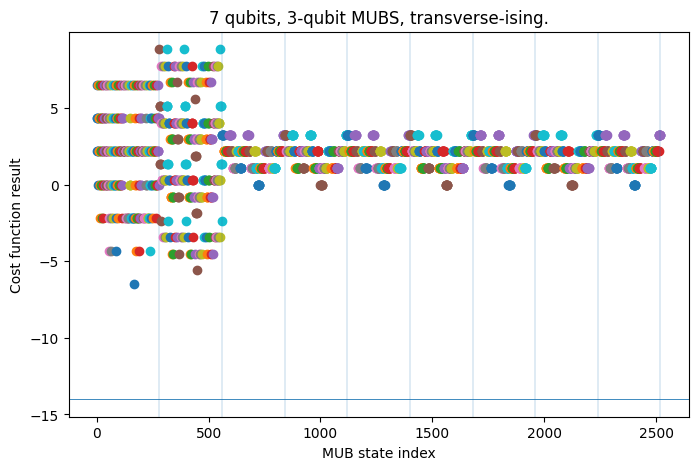

In [54]:
display_energy_landscape(results, exact_result, graph_title="7 qubits, 3-qubit MUBS, transverse-ising.")